In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [85]:
# Load the dataset
file_path = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(file_path)

In [86]:
# Preview the dataset
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [87]:
# Display the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (299, 13)


In [88]:
# Check if there are any missing values
print("Missing values in the dataset:")
print(df.isna().sum())

Missing values in the dataset:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


In [89]:
# Remove duplicate rows if any
df_withoutDuplicates = df.drop_duplicates()

In [90]:
# Check if the number of rows changed to see if there were any duplicates
df_withoutDuplicates.shape[0]

299

In [91]:
# Count the DEATH_EVENT target counts
counts = df['DEATH_EVENT'].value_counts()
print("Target distribution:")
print(counts)

Target distribution:
0    203
1     96
Name: DEATH_EVENT, dtype: int64


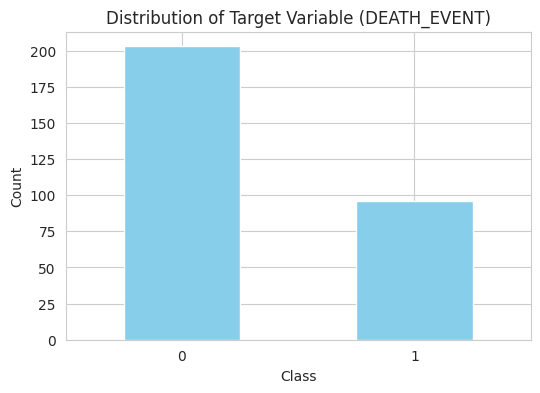

In [92]:
# Visualize the disribution of the target variable
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Target Variable (DEATH_EVENT)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

We can see that the count of Death Events with class 0, indicating that no death event occurred, is approximately double that of class 1, when a death event occurred.

In [93]:
# Function to handle outliers by capping
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

In [94]:
# List of continuous variables
continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

In [95]:
# Apply the outlier handling function to each continuous variable
for var in continuous_vars:
    df_outliersClipped = handle_outliers(df_withoutDuplicates, var)

In [96]:
# Display the statistics of the cleaned dataframe
print(df.describe())

              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.0

## Numerical Features Analysis

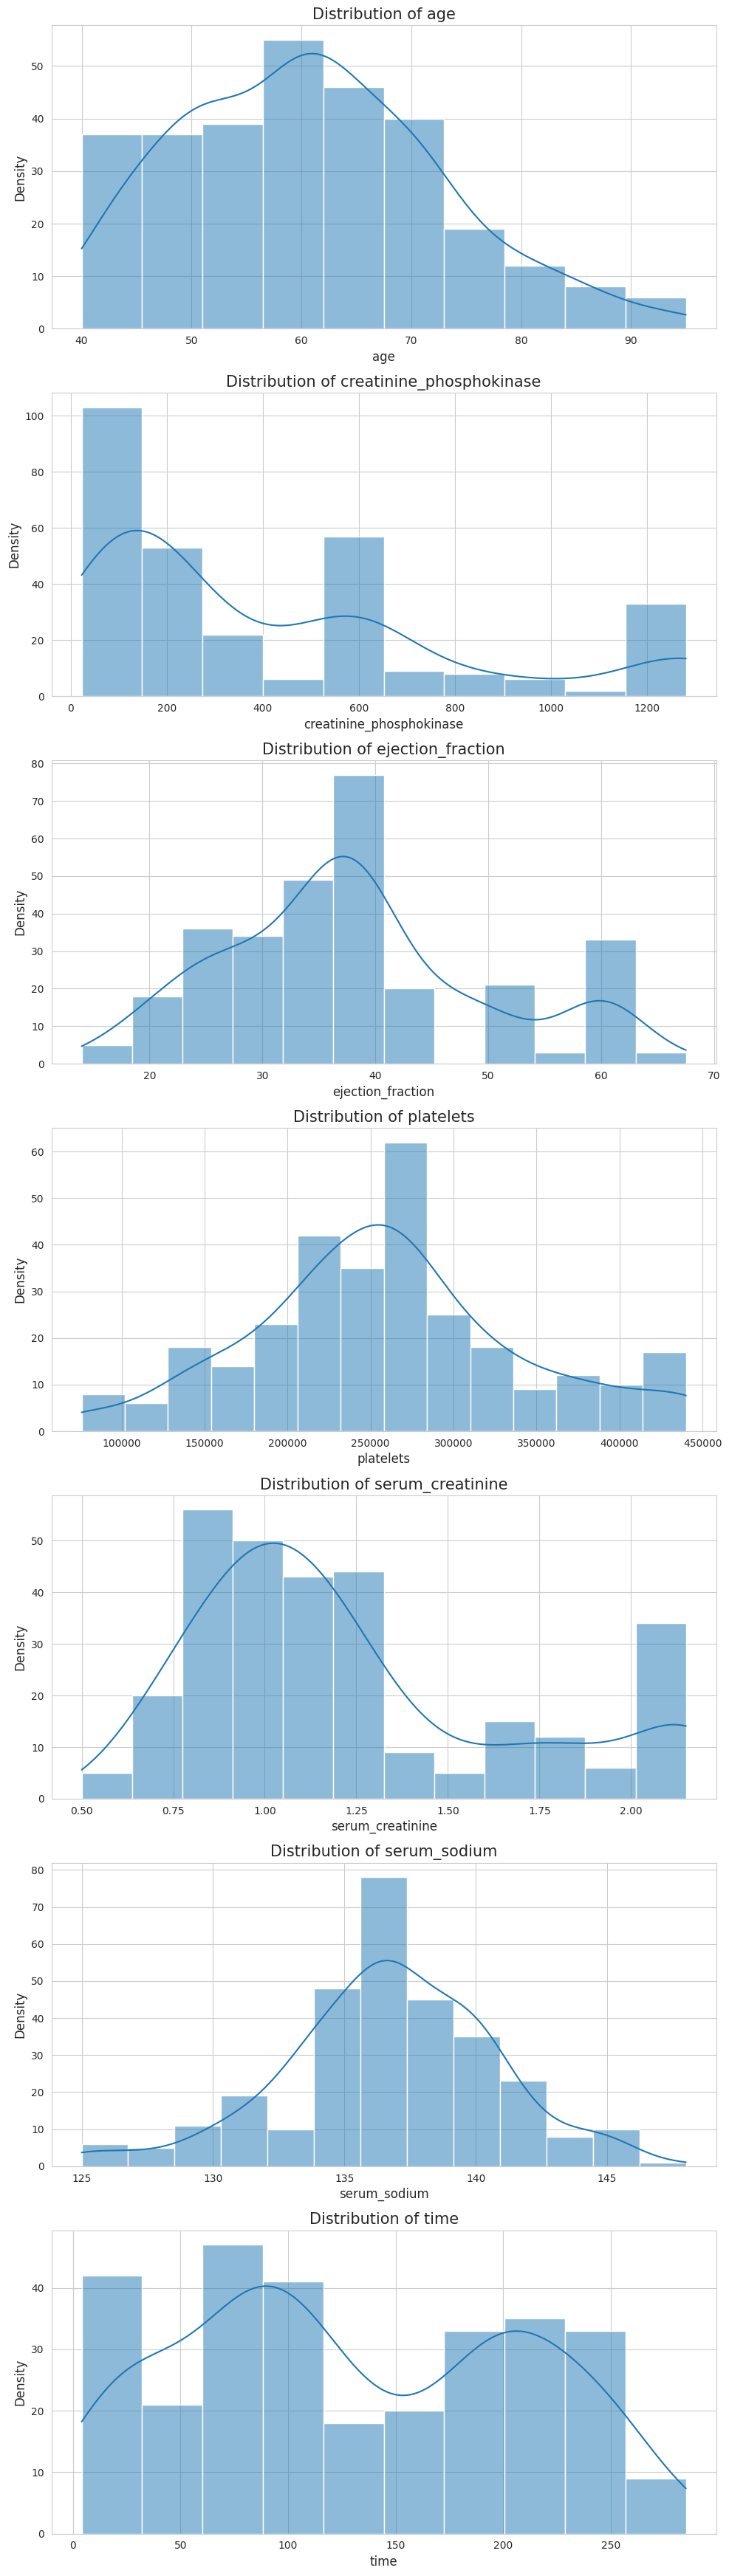

In [97]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

numerical_vars = continuous_vars + ['time']

# Define the number of plots based on the number of continuous variables
n_vars = len(numerical_vars)
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))

# Plot histograms/density plots for each continuous variable
for i, var in enumerate(numerical_vars):
    sns.histplot(df_outliersClipped[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {var}', fontsize=15)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

We can observe above the distribution of the different numerical features in our dataset. It can be clearly seen that the "platelets" and "serum_sodium" features have a normal distribution, while the "age" feature is right-skewed. StandardScaler will be used to standardize our continuous numerical features.

In [98]:
# Calculate the correlation matrix for the continuous variables
corr_matrix = df_outliersClipped[continuous_vars].corr()

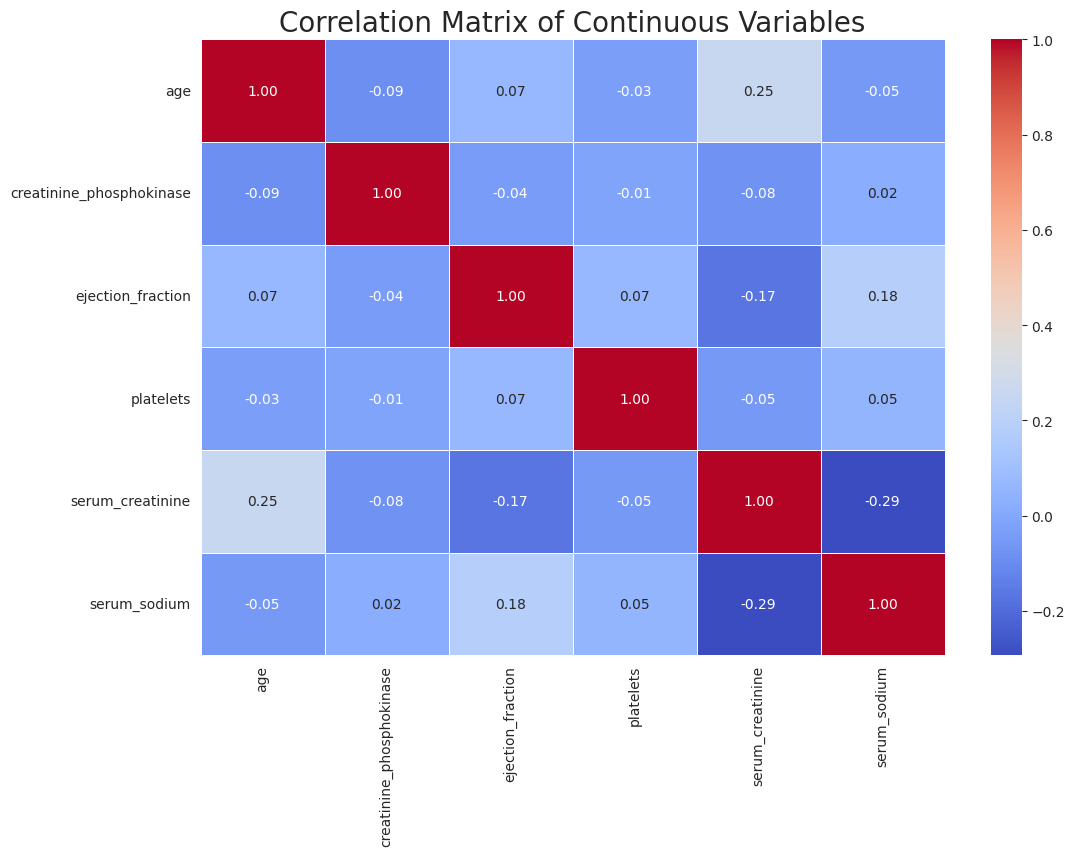

In [99]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Continuous Variables', fontsize=20)
plt.show()

From the correlation matrix above, we can see that the correlation between the different numerical features in our dataset is low and there are no highly correlated features.

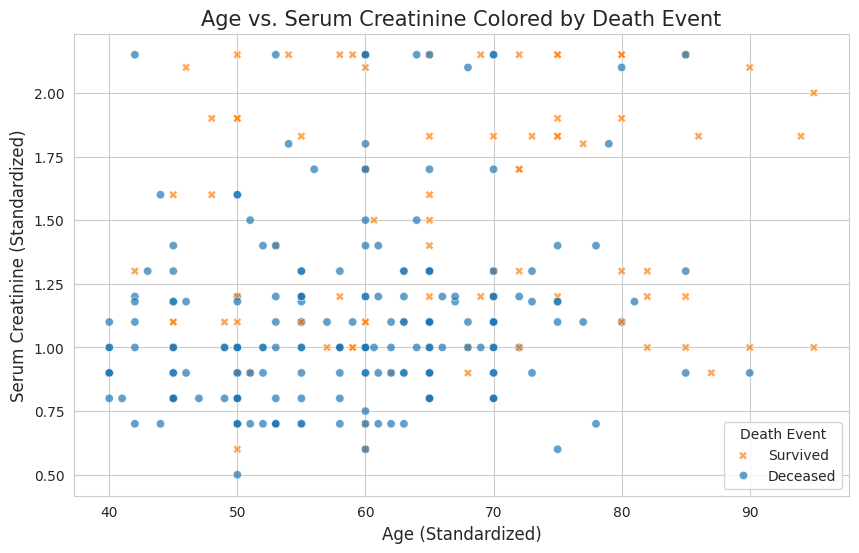

In [100]:
# For illustration, let's examine the relationship between 'age' and 'serum_creatinine'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_outliersClipped, x='age', y='serum_creatinine', hue='DEATH_EVENT', style='DEATH_EVENT', alpha=0.7)
plt.title('Age vs. Serum Creatinine Colored by Death Event', fontsize=15)
plt.xlabel('Age (Standardized)', fontsize=12)
plt.ylabel('Serum Creatinine (Standardized)', fontsize=12)
plt.legend(title='Death Event', labels=['Survived', 'Deceased'])
plt.grid(True)
plt.show()

As can be seem from the plot above, there is a weak correlation between the age and serum creatinine features.

## Categorical Features Analysis

In [101]:
# Identify binary and categorical variables excluding 'DEATH_EVENT' as it's the outcome variable
binary_categorical_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

<ipython-input-102-f17d4b3b78f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])
<ipython-input-102-f17d4b3b78f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])
<ipython-input-102-f17d4b3b78f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])
<ipython-input-102-f17d4b3b78f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])
<ipython-input-102-f17d4b3b78f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])


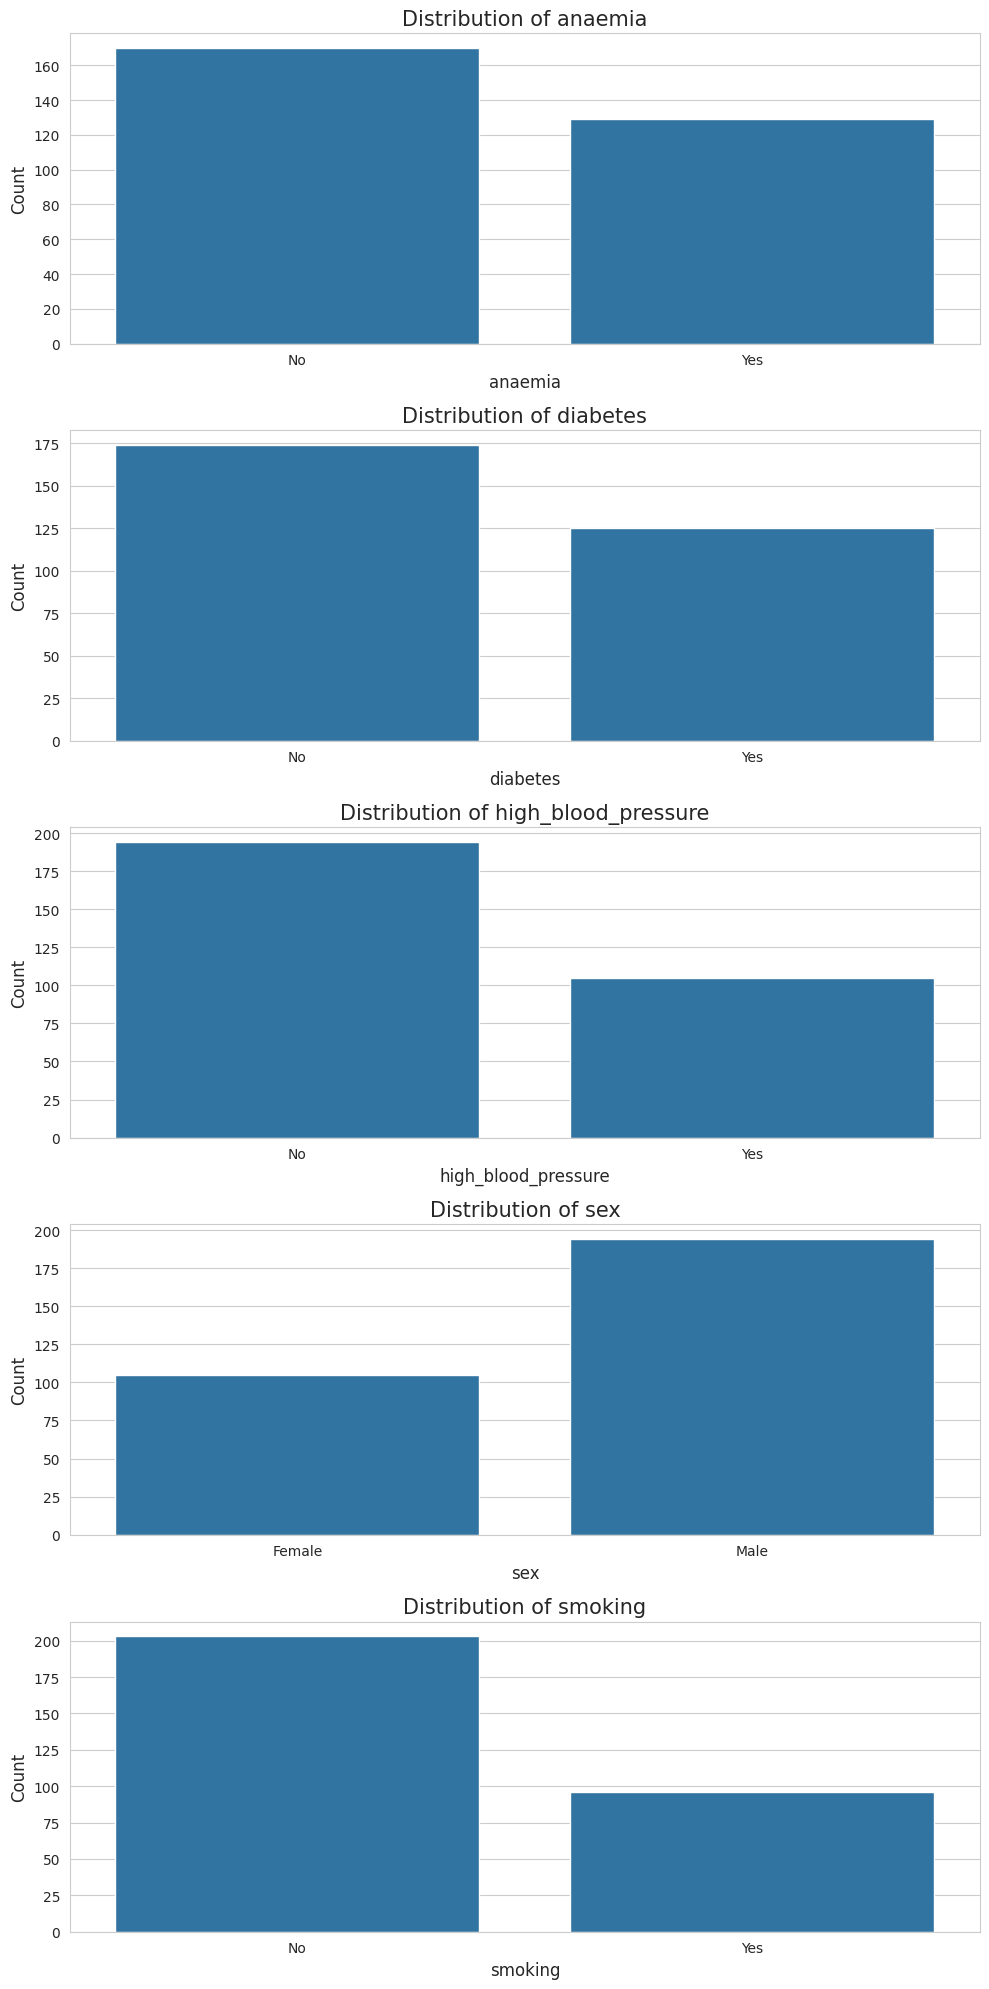

In [102]:
# Set the number of plots based on the number of binary/categorical variables
n_vars = len(binary_categorical_vars)
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 4 * n_vars))

# Plot bar plots for each categorical variable
for i, var in enumerate(binary_categorical_vars):
    sns.countplot(x=df_outliersClipped[var], ax=axes[i])
    axes[i].set_title(f'Distribution of {var}', fontsize=15)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].set_xticklabels(['No', 'Yes'] if var != 'sex' else ['Female', 'Male'])

plt.tight_layout()
plt.show()

We notice that there is no significant class imbalance for the "anaemia" and "diabetes" features. However, in the case of "high_blood_pressure", the count of the class corresponding to no high blood pressure is approximately double of that corresponding to high blood pressure. The results are similar for the "smoking" feature. We can also notice when viewing the distribution of the "sex" feature that the count of males is approximately double that of females.

In [103]:
from scipy.stats import chi2_contingency

# Create contingency tables for each pair of categorical variables
contingency_table_anaemia = pd.crosstab(df_outliersClipped['anaemia'], df_outliersClipped['DEATH_EVENT'])
contingency_table_diabetes = pd.crosstab(df_outliersClipped['diabetes'], df_outliersClipped['DEATH_EVENT'])
contingency_table_high_bp = pd.crosstab(df_outliersClipped['high_blood_pressure'], df_outliersClipped['DEATH_EVENT'])
contingency_table_sex = pd.crosstab(df_outliersClipped['sex'], df_outliersClipped['DEATH_EVENT'])
contingency_table_smoking = pd.crosstab(df_outliersClipped['smoking'], df_outliersClipped['DEATH_EVENT'])

# Perform chi-squared test for anaemia vs. DEATH_EVENT
chi2_stat_anaemia, p_val_anaemia, dof_anaemia, expected_anaemia = chi2_contingency(contingency_table_anaemia)
print("\nChi-Squared Statistic for Anaemia:", chi2_stat_anaemia)
print("P-value for Anaemia:", p_val_anaemia)

# Perform chi-squared test for diabetes vs. DEATH_EVENT
chi2_stat_diabetes, p_val_diabetes, dof_diabetes, expected_diabetes = chi2_contingency(contingency_table_diabetes)
print("\nChi-Squared Statistic for Diabetes:", chi2_stat_diabetes)
print("P-value for Diabetes:", p_val_diabetes)

# Perform chi-squared test for high_blood_pressure vs. DEATH_EVENT
chi2_stat_high_bp, p_val_high_bp, dof_high_bp, expected_high_bp = chi2_contingency(contingency_table_high_bp)
print("\nChi-Squared Statistic for High Blood Pressure:", chi2_stat_high_bp)
print("P-value for High Blood Pressure:", p_val_high_bp)

# Perform chi-squared test for sex vs. DEATH_EVENT
chi2_stat_sex, p_val_sex, dof_sex, expected_sex = chi2_contingency(contingency_table_sex)
print("\nChi-Squared Statistic for Sex:", chi2_stat_sex)
print("P-value for Sex:", p_val_sex)

# Perform chi-squared test for smoking vs. DEATH_EVENT
chi2_stat_smoking, p_val_smoking, dof_smoking, expected_smoking = chi2_contingency(contingency_table_smoking)
print("\nChi-Squared Statistic for Smoking:", chi2_stat_smoking)
print("P-value for Smoking:", p_val_smoking)


Chi-Squared Statistic for Anaemia: 1.042175485287005
P-value for Anaemia: 0.3073160508415107

Chi-Squared Statistic for Diabetes: 0.0
P-value for Diabetes: 1.0

Chi-Squared Statistic for High Blood Pressure: 1.5434607612967581
P-value for High Blood Pressure: 0.21410341199416902

Chi-Squared Statistic for Sex: 0.0
P-value for Sex: 1.0

Chi-Squared Statistic for Smoking: 0.007331473567119502
P-value for Smoking: 0.9317652998235507


The chi-squared test is a statistical test used to determine whether there is a significant association between two categorical variables.

After performing the above tests, we conclude that anaemia and high blood pressure show moderate associations with death events, but the associations are not statistically significant.

Diabetes, sex, and smoking do not show significant associations with death events based on these results, and thus can be considered for removal from the dataset.

In [104]:
# Remove the insignificant features.
df_with_removed_features = df_outliersClipped.copy()
df_with_removed_features = df_with_removed_features.drop(['diabetes','sex','smoking'], axis = 1)

In [105]:
# Preview the updated dataset
df_with_removed_features.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,75.0,0,582.00,20.0,1,265000.00,1.90,130,4,1
1,55.0,0,1280.25,38.0,0,263358.03,1.10,136,6,1
2,65.0,0,146.00,20.0,0,162000.00,1.30,129,7,1
3,50.0,1,111.00,20.0,0,210000.00,1.90,137,7,1
4,65.0,1,160.00,20.0,0,327000.00,2.15,125,8,1


# Train-Test Split

## Split with No Removed Features

In [106]:
# Split the data with no features removed into training and testing sets
X = df_outliersClipped.drop('DEATH_EVENT', axis = 1)
y = df_outliersClipped['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 4)

### Standard Scaler

In [107]:
# Scaling the continuous variables according to StandardScaler to improve model performance
scaler = StandardScaler()
X_train_standard_scaled = X_train.copy()
X_test_standard_scaled = X_test.copy()
X_train_standard_scaled[continuous_vars] = scaler.fit_transform(X_train_standard_scaled[continuous_vars])
X_test_standard_scaled[continuous_vars] = scaler.transform(X_test_standard_scaled[continuous_vars])

# Preview the training dataset with removed features and scaled according to StandardScaler
X_train_standard_scaled.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
93,-0.117619,1,-0.691789,0,-1.103643,0,-0.628876,0.999329,-0.381427,1,0,82
92,-1.600033,0,0.412065,0,1.920755,0,0.033286,-0.149363,0.106065,0,0,82
47,-0.117619,0,0.412065,1,0.019705,1,2.225374,-1.430597,0.349811,1,1,40
156,-0.776470,1,-0.939383,0,-0.239529,0,0.202580,0.336622,-0.137681,0,0,120
83,1.447151,1,-0.947120,0,1.056641,1,-1.100448,1.220232,-0.868919,1,0,78


### MinMax Scaler

In [108]:
# Scaling the continuous variables according to MinMaxScaler to improve model performance
minMax = MinMaxScaler()
X_train_minMax_scaled = X_train.copy()
X_test_minMax_scaled = X_test.copy()
X_train_minMax_scaled[continuous_vars] = minMax.fit_transform(X_train_minMax_scaled[continuous_vars])
X_test_minMax_scaled[continuous_vars] = minMax.transform(X_test_minMax_scaled[continuous_vars])

# Preview the training dataset with removed features and scaled according to MinMaxScaler
X_train_minMax_scaled.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
93,0.363636,1,0.104196,0,0.205607,0,0.368132,0.709677,0.434783,1,0,82
92,0.036364,0,0.444621,0,0.859813,0,0.514720,0.374194,0.521739,0,0,82
47,0.363636,0,0.444621,1,0.448598,1,1.000000,0.000000,0.565217,1,1,40
156,0.218182,1,0.027839,0,0.392523,0,0.552198,0.516129,0.478261,0,0,120
83,0.709091,1,0.025452,0,0.672897,1,0.263736,0.774194,0.347826,1,0,78


## Split with Removed Features

In [109]:
# Split the data with "diabetes", "sex", "smoking", and "time" features removed into training and testing sets
X_with_removed_features = df_with_removed_features.drop('DEATH_EVENT', axis = 1)
y_with_removed_features = df_with_removed_features['DEATH_EVENT']
X_train_wrf, X_test_wrf, y_train_wrf, y_test_wrf = train_test_split(X_with_removed_features, y_with_removed_features, test_size=0.2, random_state = 4)

### Standard Scaler

In [110]:
# Scaling the continuous variables according to StandardScaler to improve model performance
X_train_standard_scaled_wrf = X_train_wrf.copy()
X_test_standard_scaled_wrf = X_test_wrf.copy()
X_train_standard_scaled_wrf[continuous_vars] = scaler.fit_transform(X_train_standard_scaled_wrf[continuous_vars])
X_test_standard_scaled_wrf[continuous_vars] = scaler.transform(X_test_standard_scaled_wrf[continuous_vars])

# Preview the training dataset with removed features and scaled according to StandardScaler
X_train_standard_scaled_wrf.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,time
93,-0.117619,1,-0.691789,-1.103643,0,-0.628876,0.999329,-0.381427,82
92,-1.600033,0,0.412065,1.920755,0,0.033286,-0.149363,0.106065,82
47,-0.117619,0,0.412065,0.019705,1,2.225374,-1.430597,0.349811,40
156,-0.776470,1,-0.939383,-0.239529,0,0.202580,0.336622,-0.137681,120
83,1.447151,1,-0.947120,1.056641,1,-1.100448,1.220232,-0.868919,78


### MinMax Scaler

In [111]:
# Scaling the continuous variables according to MinMaxScaler to improve model performance
minMax = MinMaxScaler()
X_train_minMax_scaled_wrf = X_train_wrf.copy()
X_test_minMax_scaled_wrf = X_test_wrf.copy()
X_train_minMax_scaled_wrf[continuous_vars] = minMax.fit_transform(X_train_minMax_scaled_wrf[continuous_vars])
X_test_minMax_scaled_wrf[continuous_vars] = minMax.transform(X_test_minMax_scaled_wrf[continuous_vars])

# Preview the training dataset with removed features and scaled according to MinMaxScaler
X_train_minMax_scaled_wrf.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,time
93,0.363636,1,0.104196,0.205607,0,0.368132,0.709677,0.434783,82
92,0.036364,0,0.444621,0.859813,0,0.514720,0.374194,0.521739,82
47,0.363636,0,0.444621,0.448598,1,1.000000,0.000000,0.565217,40
156,0.218182,1,0.027839,0.392523,0,0.552198,0.516129,0.478261,120
83,0.709091,1,0.025452,0.672897,1,0.263736,0.774194,0.347826,78


# K Nearest Neighbors (KNN)

In [112]:
knn = KNeighborsClassifier()

kf = KFold(n_splits = 5, shuffle = True, random_state = 4)
param_grid = {'n_neighbors': np.arange(1,26)}

knn_gridsearchcv = GridSearchCV(knn, param_grid, cv = kf)

## StandardScaler & No Features Removed

In [113]:
knn_gridsearchcv.fit(X_train_standard_scaled, y_train)

standard_noFeaturesRemoved_best_params = knn_gridsearchcv.best_params_
standard_noFeaturesRemoved_best_score = knn_gridsearchcv.best_score_

print('Optimal number of neighbors:', standard_noFeaturesRemoved_best_params)
print('Best score:', standard_noFeaturesRemoved_best_score)

Optimal number of neighbors: {'n_neighbors': 8}
Best score: 0.8495567375886525


In [114]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, ConfusionMatrixDisplay

y_pred = knn_gridsearchcv.predict(X_test_standard_scaled)

standard_noFeaturesRemoved_score = knn_gridsearchcv.score(X_test_standard_scaled, y_test)
print("Accuracy of KNN classifier:", standard_noFeaturesRemoved_score)
recall_knn_1 = recall_score(y_test, y_pred)
print("Recall of KNN classifier:", recall_knn_1)
f1score_knn_1 = f1_score(y_test, y_pred)
print("F1 Score of KNN classifier:", f1score_knn_1)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy of KNN classifier: 0.8333333333333334
Recall of KNN classifier: 0.7222222222222222
F1 Score of KNN classifier: 0.7222222222222222

Confusion Matrix:
[[37  5]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.72      0.72      0.72        18

    accuracy                           0.83        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.83      0.83      0.83        60



## MinMaxScaler & No Features Removed

In [115]:
knn_gridsearchcv.fit(X_train_minMax_scaled, y_train)

minMax_noFeaturesRemoved_best_params = knn_gridsearchcv.best_params_
minMax_noFeaturesRemoved_best_score = knn_gridsearchcv.best_score_

print('Optimal number of neighbors:', minMax_noFeaturesRemoved_best_params)
print('Best score:', minMax_noFeaturesRemoved_best_score)

Optimal number of neighbors: {'n_neighbors': 8}
Best score: 0.8495567375886525


In [116]:
y_pred = knn_gridsearchcv.predict(X_test_minMax_scaled)

minMax_noFeaturesRemoved_score = knn_gridsearchcv.score(X_test_minMax_scaled, y_test)
print("Accuracy of KNN classifier:", minMax_noFeaturesRemoved_score)
recall_knn_2 = recall_score(y_test, y_pred)
print("Recall of KNN classifier:", recall_knn_2)
f1score_knn_2 = f1_score(y_test, y_pred)
print("F1 Score of KNN classifier:", f1score_knn_2)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy of KNN classifier: 0.8333333333333334
Recall of KNN classifier: 0.7222222222222222
F1 Score of KNN classifier: 0.7222222222222222

Confusion Matrix:
[[37  5]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.72      0.72      0.72        18

    accuracy                           0.83        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.83      0.83      0.83        60



## StandardScaler & Features Removed

In [117]:
knn_gridsearchcv.fit(X_train_standard_scaled_wrf, y_train_wrf)

standard_featuresRemoved_best_params = knn_gridsearchcv.best_params_
standard_featuresRemoved_best_score = knn_gridsearchcv.best_score_

print('Optimal number of neighbors:', standard_featuresRemoved_best_params)
print('Best score:', standard_featuresRemoved_best_score)

Optimal number of neighbors: {'n_neighbors': 8}
Best score: 0.8495567375886525


In [118]:
y_pred = knn_gridsearchcv.predict(X_test_standard_scaled_wrf)

standard_featuresRemoved_score = knn_gridsearchcv.score(X_test_standard_scaled_wrf, y_test)
print("Accuracy of KNN classifier:", standard_featuresRemoved_score)
recall_knn_3 = recall_score(y_test, y_pred)
print("Recall of KNN classifier:", recall_knn_3)
f1score_knn_3 = f1_score(y_test, y_pred)
print("F1 Score of KNN classifier:", f1score_knn_3)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test_wrf, y_pred))
print('\nClassification Report:')
print(classification_report(y_test_wrf, y_pred))

Accuracy of KNN classifier: 0.8333333333333334
Recall of KNN classifier: 0.7222222222222222
F1 Score of KNN classifier: 0.7222222222222222

Confusion Matrix:
[[37  5]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.72      0.72      0.72        18

    accuracy                           0.83        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.83      0.83      0.83        60



## MinMaxScaler & Features Removed

In [119]:
knn_gridsearchcv.fit(X_train_minMax_scaled_wrf, y_train_wrf)

minMax_featuresRemoved_best_params = knn_gridsearchcv.best_params_
minMax_featuresRemoved_best_score = knn_gridsearchcv.best_score_

print('Optimal number of neighbors:', minMax_featuresRemoved_best_params)
print('Best score:', minMax_featuresRemoved_best_score)

Optimal number of neighbors: {'n_neighbors': 8}
Best score: 0.8495567375886525


In [120]:
y_pred = knn_gridsearchcv.predict(X_test_minMax_scaled_wrf)

minMax_featuresRemoved_score = knn_gridsearchcv.score(X_test_minMax_scaled_wrf, y_test)
print("Accuracy of KNN classifier:", minMax_featuresRemoved_score)
recall_knn_4 = recall_score(y_test, y_pred)
print("Recall of KNN classifier:", recall_knn_4)
f1score_knn_4 = f1_score(y_test, y_pred)
print("F1 Score of KNN classifier:", f1score_knn_4)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test_wrf, y_pred))
print('\nClassification Report:')
print(classification_report(y_test_wrf, y_pred))

Accuracy of KNN classifier: 0.8333333333333334
Recall of KNN classifier: 0.7222222222222222
F1 Score of KNN classifier: 0.7222222222222222

Confusion Matrix:
[[37  5]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.72      0.72      0.72        18

    accuracy                           0.83        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.83      0.83      0.83        60



## Interpretting the results

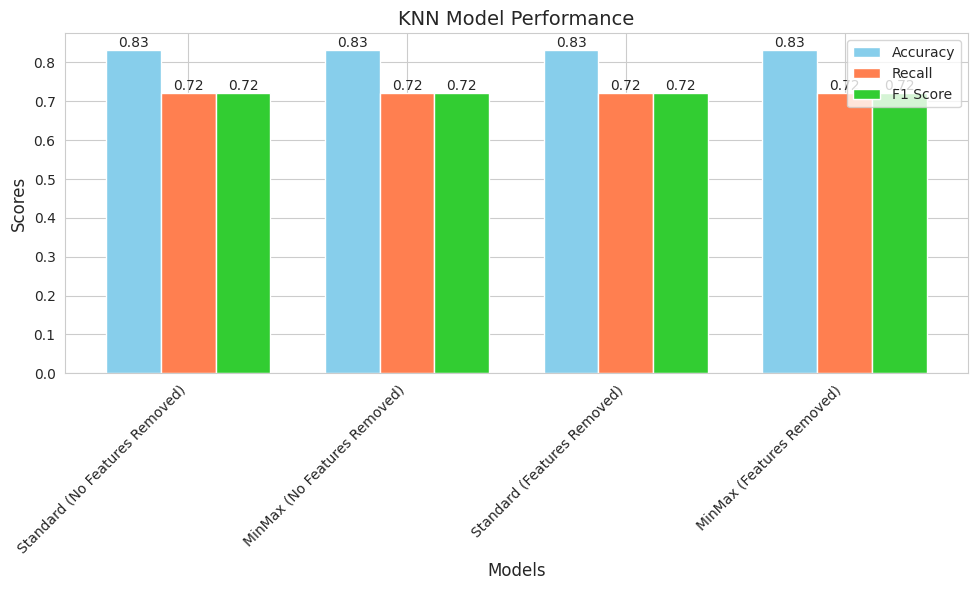

In [121]:
# Define the models and their corresponding scores
models = ['Standard (No Features Removed)', 'MinMax (No Features Removed)',
          'Standard (Features Removed)', 'MinMax (Features Removed)']

# Assuming you have calculated the scores and stored them in variables
accuracy_scores = [standard_noFeaturesRemoved_score, minMax_noFeaturesRemoved_score, standard_featuresRemoved_score, minMax_featuresRemoved_score]
recall_scores = [recall_knn_1, recall_knn_2, recall_knn_3, recall_knn_4]
f1_scores = [f1score_knn_1, f1score_knn_2, f1score_knn_3, f1score_knn_4]

# Plotting
plt.figure(figsize=(10, 6))

# Define bar widths and positions
bar_width = 0.25
positions = range(len(models))

# Plot bars for each metric
plt.bar(positions, accuracy_scores, bar_width, color='skyblue', label='Accuracy')
plt.bar([x + bar_width for x in positions], recall_scores, bar_width, color='coral', label='Recall')
plt.bar([x + 2 * bar_width for x in positions], f1_scores, bar_width, color='limegreen', label='F1 Score')

# Set labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('KNN Model Performance', fontsize=14)

# Customize ticks and legend
plt.xticks([x + bar_width for x in positions], models, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Display scores on top of bars
for i, (acc, rec, f1) in enumerate(zip(accuracy_scores, recall_scores, f1_scores)):
    plt.text(i, acc, round(acc, 2), ha='center', va='bottom')
    plt.text(i + bar_width, rec, round(rec, 2), ha='center', va='bottom')
    plt.text(i + 2 * bar_width, f1, round(f1, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

We can notice that all the models trained on each of the datasets, scaled using StandardScaler or MinMax Scaler and with insignificant features not removed or scaled using standardScaler or minMax scaler and with isignificant features removed, were able to achieve the same accuracy on the unseen test data, with a score of 83.33%.

Our results highlight the fact that the features that were removed were in fact insingicant as the same performance was yielded on all datasets with and without insignificant features removed.

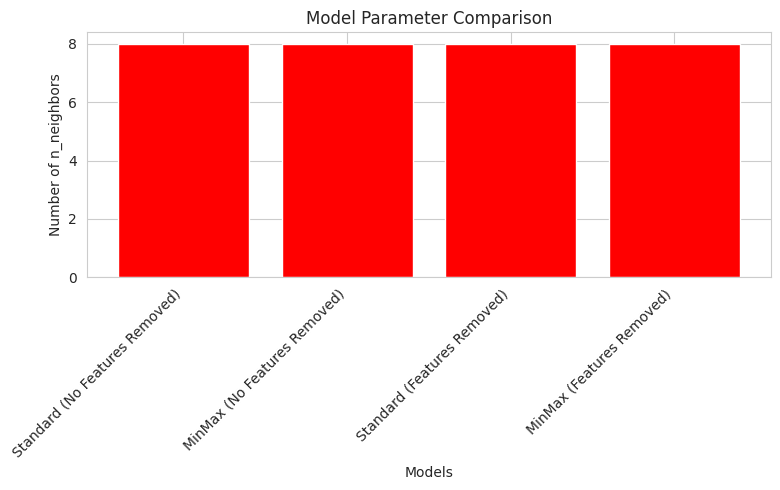

In [122]:
neighbors = [standard_noFeaturesRemoved_best_params['n_neighbors'], minMax_noFeaturesRemoved_best_params['n_neighbors'], standard_featuresRemoved_best_params['n_neighbors'], minMax_featuresRemoved_best_params['n_neighbors']]

plt.figure(figsize=(8, 5))
plt.bar(models, neighbors, color = 'red')
plt.xlabel('Models')
plt.ylabel('Number of n_neighbors')
plt.title('Model Parameter Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We can see from the above graph that when using GridSearch to find the optimal number of n_neighbors for the KNN model, n_neighbors value of 8 was chosen to be optimal in all of the 4 KNN models.

# Support Vector Machines (SVM)

In [ ]:
svm = SVC()

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
param_grid = {'C': [0.0001, 0.001, 0.1, 1],
              'gamma': [0.01, 0.1, 1, 10],
              'kernel': ['linear', 'rbf']}

svm_gridsearchcv = GridSearchCV(svm, param_grid, cv=kf )

## StandardScaler & No Features Removed

In [ ]:
svm_gridsearchcv.fit(X_train_standard_scaled, y_train)

svm_standard_noFeaturesRemoved_best_params = svm_gridsearchcv.best_params_
svm_standard_noFeaturesRemoved_best_score = svm_gridsearchcv.best_score_

print('Optimal params:', svm_standard_noFeaturesRemoved_best_params)
print('Best score:', svm_standard_noFeaturesRemoved_best_score)

Optimal params: {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
Best score: 0.8409574468085106


In [ ]:
y_pred = svm_gridsearchcv.predict(X_test_standard_scaled)

svm_standard_noFeaturesRemoved_accuracy_score = svm_gridsearchcv.score(X_test_standard_scaled, y_test)
print('Accuracy of SVM classifier:', svm_standard_noFeaturesRemoved_accuracy_score)

svm_standard_noFeaturesRemoved_recall_score = recall_score(y_test, y_pred)
print("Recall of SVM classifier:", svm_standard_noFeaturesRemoved_recall_score)

svm_standard_noFeaturesRemoved_f1_score = f1_score(y_test, y_pred)
print("F1 of SVM:", svm_standard_noFeaturesRemoved_f1_score)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy of SVM classifier: 0.8666666666666667
Recall of SVM classifier: 0.7222222222222222
F1 of SVM: 0.7647058823529411

Confusion Matrix:
[[39  3]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.81      0.72      0.76        18

    accuracy                           0.87        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.86      0.87      0.86        60



## MinMaxScaler & No Features Removed

In [ ]:
svm_gridsearchcv.fit(X_train_minMax_scaled, y_train)

svm_minMax_noFeaturesRemoved_best_params = svm_gridsearchcv.best_params_
svm_minMax_noFeaturesRemoved_best_score = svm_gridsearchcv.best_score_

print('Optimal params:', svm_minMax_noFeaturesRemoved_best_params)
print('Best score:', svm_minMax_noFeaturesRemoved_best_score)

Optimal params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best score: 0.8493794326241135


In [ ]:
y_pred = svm_gridsearchcv.predict(X_test_minMax_scaled)

svm_minMax_noFeaturesRemoved_accuracy_score = svm_gridsearchcv.score(X_test_minMax_scaled, y_test)
print('Accuracy of SVM classifier:', svm_minMax_noFeaturesRemoved_accuracy_score)

svm_minMax_noFeaturesRemoved_recall_score = recall_score(y_test, y_pred)
print("Recall of SVM classifier:", svm_minMax_noFeaturesRemoved_recall_score)

svm_minMax_noFeaturesRemoved_f1_score = f1_score(y_test, y_pred)
print("F1 of SVM classifier:", svm_minMax_noFeaturesRemoved_f1_score)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy of SVM classifier: 0.8333333333333334
Recall of SVM classifier: 0.6111111111111112
F1 of SVM classifier: 0.6875000000000001

Confusion Matrix:
[[39  3]
 [ 7 11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.79      0.61      0.69        18

    accuracy                           0.83        60
   macro avg       0.82      0.77      0.79        60
weighted avg       0.83      0.83      0.83        60



## StandardScaler & Features Removed

In [ ]:
svm_gridsearchcv.fit(X_train_standard_scaled_wrf, y_train_wrf)

svm_standard_featuresRemoved_best_params = svm_gridsearchcv.best_params_
svm_standard_featuresRemoved_best_score = svm_gridsearchcv.best_score_

print('Optimal params:', svm_standard_featuresRemoved_best_params)
print('Best score:', svm_standard_featuresRemoved_best_score)

Optimal params: {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
Best score: 0.8409574468085106


In [ ]:
y_pred = svm_gridsearchcv.predict(X_test_standard_scaled_wrf)

svm_standard_featuresRemoved_accuracy_score = svm_gridsearchcv.score(X_test_standard_scaled_wrf, y_test)
print('Accuracy of SVM classifier:', svm_standard_featuresRemoved_accuracy_score)

svm_standard_featuresRemoved_recall_score = recall_score(y_test, y_pred)
print("Recall of SVM classifier:", svm_standard_featuresRemoved_recall_score)

svm_standard_featuresRemoved_f1_score = f1_score(y_test, y_pred)
print("F1 of SVM classifier:", svm_standard_featuresRemoved_f1_score)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test_wrf, y_pred))
print('\nClassification Report:')
print(classification_report(y_test_wrf, y_pred))

Accuracy of SVM classifier: 0.8666666666666667
Recall of SVM classifier: 0.7222222222222222
F1 of SVM classifier: 0.7647058823529411

Confusion Matrix:
[[39  3]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.81      0.72      0.76        18

    accuracy                           0.87        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.86      0.87      0.86        60



## MinMaxScaler & Features Removed

In [ ]:
svm_gridsearchcv.fit(X_train_minMax_scaled_wrf, y_train_wrf)

svm_minMax_featuresRemoved_best_params = svm_gridsearchcv.best_params_
svm_minMax_featuresRemoved_best_score = svm_gridsearchcv.best_score_

print('Optimal params:', svm_minMax_featuresRemoved_best_params)
print('Best score:', svm_minMax_featuresRemoved_best_score)

Optimal params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best score: 0.8493794326241135


In [ ]:
y_pred = svm_gridsearchcv.predict(X_test_minMax_scaled_wrf)

svm_minMax_featuresRemoved_accuracy_score = svm_gridsearchcv.score(X_test_minMax_scaled_wrf, y_test)
print('Accuracy of SVM classifier:', svm_minMax_featuresRemoved_accuracy_score)

svm_minMax_featuresRemoved_recall_score = recall_score(y_test, y_pred)
print("Recall of SVM classifier:", svm_minMax_featuresRemoved_recall_score)

svm_minMax_featuresRemoved_f1_score = f1_score(y_test, y_pred)
print("F1 of SVM classifier:", svm_minMax_featuresRemoved_f1_score)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test_wrf, y_pred))
print('\nClassification Report:')
print(classification_report(y_test_wrf, y_pred))

Accuracy of SVM classifier: 0.85
Recall of SVM classifier: 0.7222222222222222
F1 of SVM classifier: 0.7428571428571428

Confusion Matrix:
[[38  4]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        42
           1       0.76      0.72      0.74        18

    accuracy                           0.85        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.85      0.85      0.85        60



## Interpretting the results

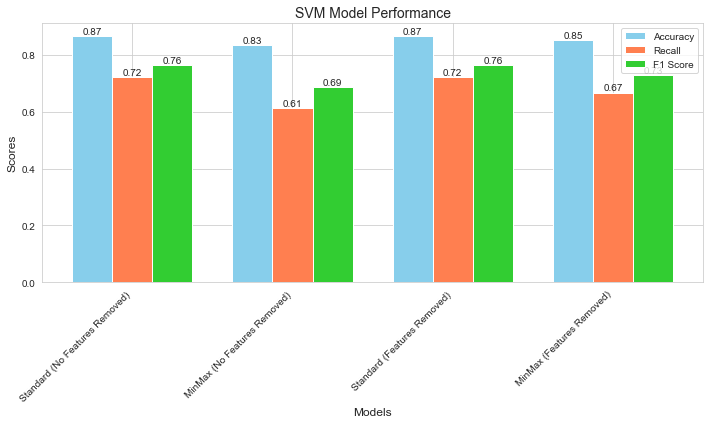

In [ ]:
# Define the models and their corresponding scores
models = ['Standard (No Features Removed)', 'MinMax (No Features Removed)',
          'Standard (Features Removed)', 'MinMax (Features Removed)']

accuracy_scores = [svm_standard_noFeaturesRemoved_accuracy_score, svm_minMax_noFeaturesRemoved_accuracy_score, svm_standard_featuresRemoved_accuracy_score, svm_minMax_featuresRemoved_accuracy_score]
recall_scores = [svm_standard_noFeaturesRemoved_recall_score, svm_minMax_noFeaturesRemoved_recall_score, svm_standard_featuresRemoved_recall_score, svm_minMax_featuresRemoved_recall_score]
f1_scores = [svm_standard_noFeaturesRemoved_f1_score, svm_minMax_noFeaturesRemoved_f1_score, svm_standard_featuresRemoved_f1_score, svm_minMax_featuresRemoved_f1_score]

# Plotting
plt.figure(figsize=(10, 6))

# Define bar widths and positions
bar_width = 0.25
positions = range(len(models))

# Plot bars for each metric
plt.bar(positions, accuracy_scores, bar_width, color='skyblue', label='Accuracy')
plt.bar([x + bar_width for x in positions], recall_scores, bar_width, color='coral', label='Recall')
plt.bar([x + 2 * bar_width for x in positions], f1_scores, bar_width, color='limegreen', label='F1 Score')

# Set labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('SVM Model Performance', fontsize=14)

# Customize ticks and legend
plt.xticks([x + bar_width for x in positions], models, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Display scores on top of bars
for i, (acc, rec, f1) in enumerate(zip(accuracy_scores, recall_scores, f1_scores)):
    plt.text(i, acc, round(acc, 2), ha='center', va='bottom')
    plt.text(i + bar_width, rec, round(rec, 2), ha='center', va='bottom')
    plt.text(i + 2 * bar_width, f1, round(f1, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Analyzing the graphs above, we can notice that scenario 1 (using standard scalar with no features removed) and 3 (using standard scalar with features removed) obtained the highest accuracy of 87%. Scenario 4 where the MinMax scalar was used with the removal of features obtained a lesser accuracy of 85%. Finally, scenario 2 (using MinMax scalar with no removed features) obtained the least accuracy of 83%.

# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
# Initialize Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=4, class_weight='balanced')
kf = KFold(n_splits = 5, shuffle = True, random_state = 10)

#Initialize the GridSearch
grid_search_DT = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, verbose=1)

## StandardScaler & No Features Removed

In [ ]:
grid_search_DT.fit(X_train_standard_scaled, y_train)

DT_standard_noFeaturesRemoved_best_params = grid_search_DT.best_params_
DT_standard_noFeaturesRemoved_best_score = grid_search_DT.best_score_

print('Optimal number of params:', DT_standard_noFeaturesRemoved_best_params)
print('Best score:', DT_standard_noFeaturesRemoved_best_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimal number of params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: 0.7992021276595744


In [ ]:
# Predict on the test set
y_pred_dt = grid_search_DT.predict(X_test_standard_scaled)

# Evaluate the model
accuracy_dt_1 = accuracy_score(y_test, y_pred_dt)
print("Accuracy of Decision Tree classifier:", accuracy_dt_1)
recall_dt_1 = recall_score(y_test, y_pred_dt)
print("Recall of Decision Tree classifier:", recall_dt_1)
f1score_dt_1 = f1_score(y_test, y_pred_dt)
print("F1 Score of Decision Tree classifier:", f1score_dt_1)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy of Decision Tree classifier: 0.7166666666666667
Recall of Decision Tree classifier: 0.6666666666666666
F1 Score of Decision Tree classifier: 0.5853658536585366
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        42
           1       0.52      0.67      0.59        18

    accuracy                           0.72        60
   macro avg       0.68      0.70      0.69        60
weighted avg       0.74      0.72      0.72        60

Confusion Matrix:
[[31 11]
 [ 6 12]]


## MinMaxScaler & No Features Removed


In [ ]:
grid_search_DT.fit(X_train_minMax_scaled, y_train)

DT_minmax_noFeaturesRemoved_best_params = grid_search_DT.best_params_
DT_minmax_noFeaturesRemoved_best_score = grid_search_DT.best_score_

print('Optimal number of params:', DT_minmax_noFeaturesRemoved_best_params)
print('Best score:', DT_minmax_noFeaturesRemoved_best_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimal number of params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: 0.7992021276595744


In [ ]:
# Predict on the test set
y_pred_dt = grid_search_DT.predict(X_test_minMax_scaled)

# Evaluate the model
accuracy_dt_2 = accuracy_score(y_test, y_pred_dt)
print("Accuracy of Decision Tree classifier:", accuracy_dt_2)
recall_dt_2 = recall_score(y_test, y_pred_dt)
print("Recall of Decision Tree classifier:", recall_dt_2)
f1score_dt_2 = f1_score(y_test, y_pred_dt)
print("F1 Score of Decision Tree classifier:", f1score_dt_2)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy of Decision Tree classifier: 0.7166666666666667
Recall of Decision Tree classifier: 0.6666666666666666
F1 Score of Decision Tree classifier: 0.5853658536585366
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        42
           1       0.52      0.67      0.59        18

    accuracy                           0.72        60
   macro avg       0.68      0.70      0.69        60
weighted avg       0.74      0.72      0.72        60

Confusion Matrix:
[[31 11]
 [ 6 12]]


## StandardScaler & Features Removed

In [ ]:
grid_search_DT.fit(X_train_standard_scaled_wrf, y_train_wrf)

DT_standard_featuresRemoved_best_params = grid_search_DT.best_params_
DT_standard_featuresRemoved_best_score = grid_search_DT.best_score_

print('Optimal number of params:', DT_standard_featuresRemoved_best_params)
print('Best score:', DT_standard_featuresRemoved_best_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimal number of params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best score: 0.8201241134751772


In [ ]:
# Predict on the test set
y_pred_dt = grid_search_DT.predict(X_test_standard_scaled_wrf)

# Evaluate the model
accuracy_dt_3 = accuracy_score(y_test, y_pred_dt)
print("Accuracy of Decision Tree classifier:", accuracy_dt_3)
recall_dt_3 = recall_score(y_test, y_pred_dt)
print("Recall of Decision Tree classifier:", recall_dt_3)
f1score_dt_3 = f1_score(y_test, y_pred_dt)
print("F1 Score of Decision Tree classifier:", f1score_dt_3)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy of Decision Tree classifier: 0.7
Recall of Decision Tree classifier: 0.5555555555555556
F1 Score of Decision Tree classifier: 0.5263157894736842
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        42
           1       0.50      0.56      0.53        18

    accuracy                           0.70        60
   macro avg       0.65      0.66      0.65        60
weighted avg       0.71      0.70      0.70        60

Confusion Matrix:
[[32 10]
 [ 8 10]]


## MinMaxScaler & Features Removed

In [ ]:
grid_search_DT.fit(X_train_minMax_scaled_wrf, y_train_wrf)

DT_minmax_featuresRemoved_best_params = grid_search_DT.best_params_
DT_minmax_featuresRemoved_best_score = grid_search_DT.best_score_

print('Optimal number of params:', DT_minmax_featuresRemoved_best_params)
print('Best score:', DT_minmax_featuresRemoved_best_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimal number of params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best score: 0.8201241134751772


In [ ]:
# Predict on the test set
y_pred_dt = grid_search_DT.predict(X_test_minMax_scaled_wrf)

# Evaluate the model
accuracy_dt_4 = accuracy_score(y_test, y_pred_dt)
print("Accuracy of Decision Tree classifier:", accuracy_dt_4)
recall_dt_4 = recall_score(y_test, y_pred_dt)
print("Recall of Decision Tree classifier:", recall_dt_4)
f1score_dt_4 = f1_score(y_test, y_pred_dt)
print("F1 Score of Decision Tree classifier:", f1score_dt_4)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy of Decision Tree classifier: 0.7
Recall of Decision Tree classifier: 0.5555555555555556
F1 Score of Decision Tree classifier: 0.5263157894736842
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        42
           1       0.50      0.56      0.53        18

    accuracy                           0.70        60
   macro avg       0.65      0.66      0.65        60
weighted avg       0.71      0.70      0.70        60

Confusion Matrix:
[[32 10]
 [ 8 10]]


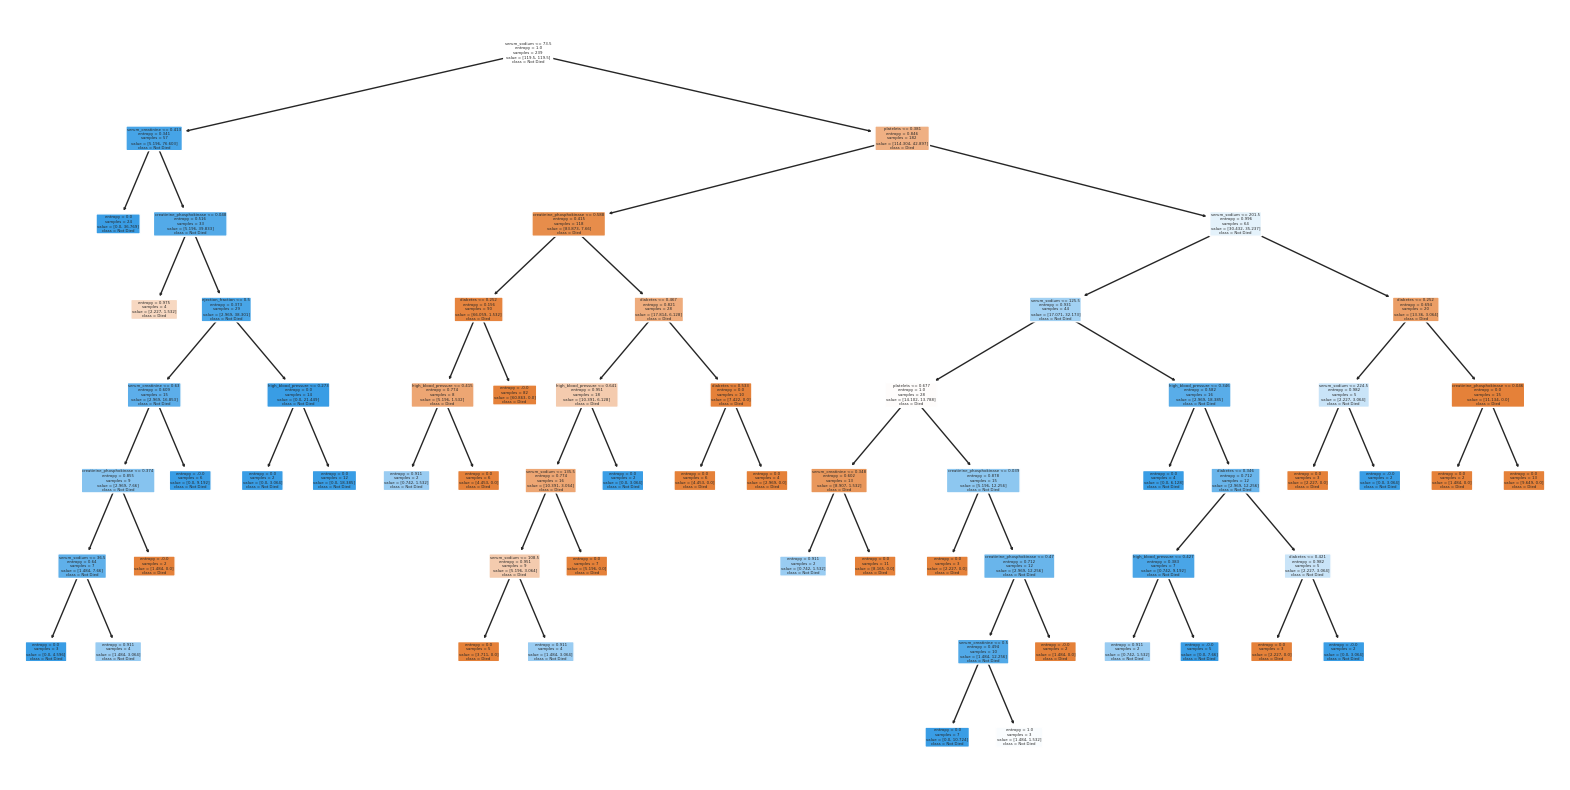

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

best_tree_model = grid_search_DT.best_estimator_

plt.figure(figsize=(20,10))
plot_tree(best_tree_model, filled=True, rounded=True, class_names=["Died", "Not Died"], feature_names=X.columns)
plt.show()



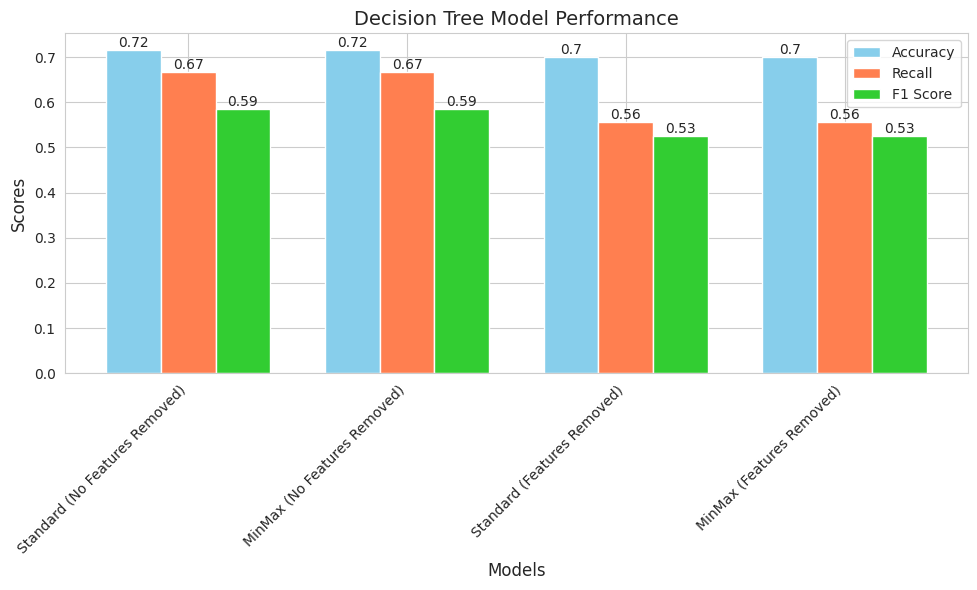

In [ ]:
# Define the models and their corresponding scores
models = ['Standard (No Features Removed)', 'MinMax (No Features Removed)',
          'Standard (Features Removed)', 'MinMax (Features Removed)']
accuracy_scores = [accuracy_dt_1, accuracy_dt_2, accuracy_dt_3, accuracy_dt_4]
recall_scores = [recall_dt_1, recall_dt_2, recall_dt_3, recall_dt_4]
f1_scores = [f1score_dt_1, f1score_dt_2, f1score_dt_3, f1score_dt_4]

# Plotting
plt.figure(figsize=(10, 6))

# Define bar widths and positions
bar_width = 0.25
positions = range(len(models))

# Plot bars for each metric
plt.bar(positions, accuracy_scores, bar_width, color='skyblue', label='Accuracy')
plt.bar([x + bar_width for x in positions], recall_scores, bar_width, color='coral', label='Recall')
plt.bar([x + 2 * bar_width for x in positions], f1_scores, bar_width, color='limegreen', label='F1 Score')

# Set labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Decision Tree Model Performance', fontsize=14)

# Customize ticks and legend
plt.xticks([x + bar_width for x in positions], models, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Display scores on top of bars
for i, (acc, rec, f1) in enumerate(zip(accuracy_scores, recall_scores, f1_scores)):
    plt.text(i, acc, round(acc, 2), ha='center', va='bottom')
    plt.text(i + bar_width, rec, round(rec, 2), ha='center', va='bottom')
    plt.text(i + 2 * bar_width, f1, round(f1, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Initialize Random Forest classifier
random_forest = RandomForestClassifier(random_state=4, class_weight='balanced')

kf = KFold(n_splits = 5, shuffle = True, random_state = 10)

# Initialize GridSearchCV
grid_search_RF = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)


## StandardScaler & No Features Removed

In [ ]:
grid_search_RF.fit(X_train_standard_scaled, y_train)

RF_standard_noFeaturesRemoved_best_params = grid_search_RF.best_params_
RF_standard_noFeaturesRemoved_best_score = grid_search_RF.best_score_

print('Optimal number of params:', RF_standard_noFeaturesRemoved_best_params)
print('Best score:', RF_standard_noFeaturesRemoved_best_score)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Optimal number of params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8662234042553191


In [ ]:
# Predict on the test set
y_pred_rf = grid_search_RF.predict(X_test_standard_scaled)

# Evaluate the model
accuracy_rf_1 = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest classifier:", accuracy_rf_1)
recall_rf_1 = recall_score(y_test, y_pred_rf)
print("Recall of Random Forest classifier:", recall_rf_1)
f1score_rf_1 = f1_score(y_test, y_pred_rf)
print("F1 Score of Random Forest classifier:", f1score_rf_1)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy of Random Forest classifier: 0.8666666666666667
Recall of Random Forest classifier: 0.7222222222222222
F1 Score of Random Forest classifier: 0.7647058823529411
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.81      0.72      0.76        18

    accuracy                           0.87        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.86      0.87      0.86        60

Confusion Matrix:
[[39  3]
 [ 5 13]]


## MinMaxScaler & No Features Removed

In [ ]:
grid_search_RF.fit(X_train_minMax_scaled, y_train)

RF_minmax_noFeaturesRemoved_best_params = grid_search_RF.best_params_
RF_minmax_noFeaturesRemoved_best_score = grid_search_RF.best_score_

print('Optimal number of params:', RF_minmax_noFeaturesRemoved_best_params)
print('Best score:', RF_minmax_noFeaturesRemoved_best_score)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Optimal number of params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.8703014184397162


In [ ]:
# Predict on the test set
y_pred_rf = grid_search_RF.predict(X_test_minMax_scaled)

# Evaluate the model
accuracy_rf_2 = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest classifier:", accuracy_rf_2)
recall_rf_2 = recall_score(y_test, y_pred_rf)
print("Recall of Random Forest classifier:", recall_rf_2)
f1score_rf_2 = f1_score(y_test, y_pred_rf)
print("F1 Score of Random Forest classifier:", f1score_rf_2)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy of Random Forest classifier: 0.8833333333333333
Recall of Random Forest classifier: 0.8333333333333334
F1 Score of Random Forest classifier: 0.8108108108108109
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        42
           1       0.79      0.83      0.81        18

    accuracy                           0.88        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.89      0.88      0.88        60

Confusion Matrix:
[[38  4]
 [ 3 15]]


## StandardScaler & Features Removed

In [ ]:
grid_search_RF.fit(X_train_standard_scaled_wrf, y_train_wrf)

RF_standard_featuresRemoved_best_params = grid_search_RF.best_params_
RF_standard_featuresRemoved_best_score = grid_search_RF.best_score_

print('Optimal number of params:', RF_standard_featuresRemoved_best_params)
print('Best score:', RF_standard_featuresRemoved_best_score)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Optimal number of params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8535460992907801


In [ ]:
# Predict on the test set
y_pred_rf = grid_search_RF.predict(X_test_standard_scaled_wrf)

# Evaluate the model
accuracy_rf_3 = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest classifier:", accuracy_rf_3)
recall_rf_3 = recall_score(y_test, y_pred_rf)
print("Recall of Random Forest classifier:", recall_rf_3)
f1score_rf_3 = f1_score(y_test, y_pred_rf)
print("F1 Score of Random Forest classifier:", f1score_rf_3)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy of Random Forest classifier: 0.8166666666666667
Recall of Random Forest classifier: 0.7777777777777778
F1 Score of Random Forest classifier: 0.717948717948718
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.67      0.78      0.72        18

    accuracy                           0.82        60
   macro avg       0.78      0.81      0.79        60
weighted avg       0.83      0.82      0.82        60

Confusion Matrix:
[[35  7]
 [ 4 14]]


## MinMaxScaler & Features Removed

In [ ]:
grid_search_RF.fit(X_train_minMax_scaled_wrf, y_train_wrf)

RF_minmax_featuresRemoved_best_params = grid_search_RF.best_params_
RF_minmax_featuresRemoved_best_score = grid_search_RF.best_score_

print('Optimal number of params:', RF_minmax_featuresRemoved_best_params)
print('Best score:', RF_minmax_featuresRemoved_best_score)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Optimal number of params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8535460992907801


In [ ]:
# Predict on the test set
y_pred_rf = grid_search_RF.predict(X_test_minMax_scaled_wrf)

# Evaluate the model
accuracy_rf_4 = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest classifier:", accuracy_rf_4)
recall_rf_4 = recall_score(y_test, y_pred_rf)
print("Recall of Random Forest classifier:", recall_rf_4)
f1score_rf_4 = f1_score(y_test, y_pred_rf)
print("F1 Score of Random Forest classifier:", f1score_rf_4)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy of Random Forest classifier: 0.8166666666666667
Recall of Random Forest classifier: 0.7777777777777778
F1 Score of Random Forest classifier: 0.717948717948718
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.67      0.78      0.72        18

    accuracy                           0.82        60
   macro avg       0.78      0.81      0.79        60
weighted avg       0.83      0.82      0.82        60

Confusion Matrix:
[[35  7]
 [ 4 14]]


## Visualize the results

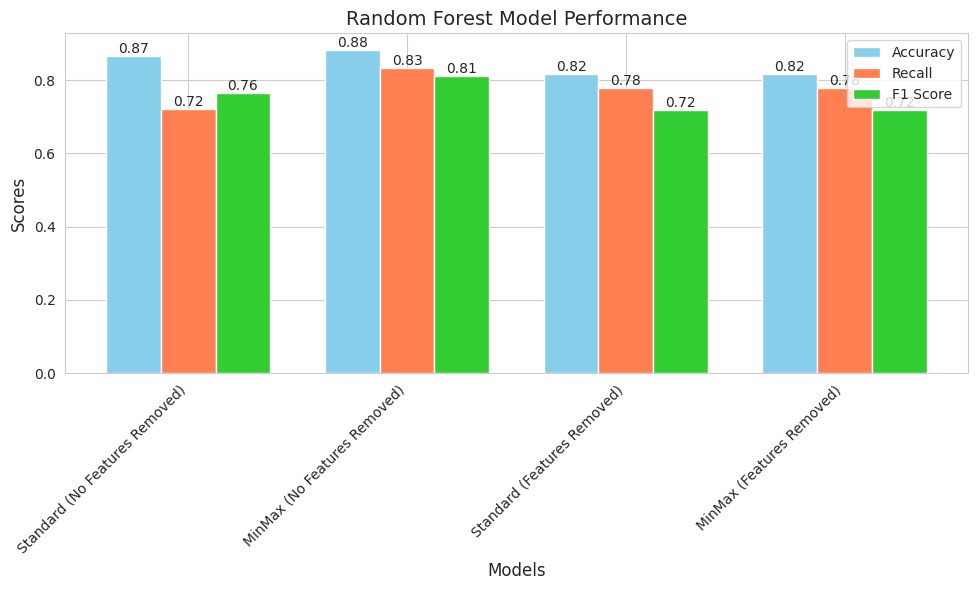

In [ ]:
# Define the models and their corresponding scores
models = ['Standard (No Features Removed)', 'MinMax (No Features Removed)',
          'Standard (Features Removed)', 'MinMax (Features Removed)']
accuracy_scores = [accuracy_rf_1, accuracy_rf_2, accuracy_rf_3, accuracy_rf_4]
recall_scores = [recall_rf_1, recall_rf_2, recall_rf_3, recall_rf_4]
f1_scores = [f1score_rf_1, f1score_rf_2, f1score_rf_3, f1score_rf_4]

# Plotting
plt.figure(figsize=(10, 6))

# Define bar widths and positions
bar_width = 0.25
positions = range(len(models))

# Plot bars for each metric
plt.bar(positions, accuracy_scores, bar_width, color='skyblue', label='Accuracy')
plt.bar([x + bar_width for x in positions], recall_scores, bar_width, color='coral', label='Recall')
plt.bar([x + 2 * bar_width for x in positions], f1_scores, bar_width, color='limegreen', label='F1 Score')

# Set labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Random Forest Model Performance', fontsize=14)

# Customize ticks and legend
plt.xticks([x + bar_width for x in positions], models, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Display scores on top of bars
for i, (acc, rec, f1) in enumerate(zip(accuracy_scores, recall_scores, f1_scores)):
    plt.text(i, acc, round(acc, 2), ha='center', va='bottom')
    plt.text(i + bar_width, rec, round(rec, 2), ha='center', va='bottom')
    plt.text(i + 2 * bar_width, f1, round(f1, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import uniform

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)

param_grid = [
    {'solver' : ['newton-cg'],
      'penalty' : ['l2'],
      'max_iter' : [50,100,200,500,1000,2500],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
]

kf = KFold(n_splits = 5, shuffle = True, random_state = 4)

logistic_regression_grid_search = GridSearchCV(logistic_regression, param_grid=param_grid, cv=kf, error_score='raise')

## Standard Scaler and No Features Removed

In [ ]:
logistic_regression_grid_search.fit(X_train_standard_scaled, y_train)

logistic_regression_standard_noFeaturesRemoved_best_params = logistic_regression_grid_search.best_params_
logistic_regression_standard_noFeaturesRemoved_best_score = logistic_regression_grid_search.best_score_

print('Optimal number of params:', logistic_regression_standard_noFeaturesRemoved_best_params)
print('Best score:', logistic_regression_standard_noFeaturesRemoved_best_score)

Optimal number of params: {'C': 0.01, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.8370567375886525


In [ ]:
# Predict on the test set
y_pred_logistic_regression = logistic_regression_grid_search.predict(X_test_standard_scaled)

# Evaluate the model
accuracy_logreg_1 = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy of Logistic Regression classifier:", accuracy_logreg_1)
recall_logreg_1 = recall_score(y_test, y_pred_logistic_regression)
print("Recall of Logistic Regression classifier:", recall_logreg_1)
f1score_logreg_1 = f1_score(y_test, y_pred_logistic_regression)
print("F1 Score of Logistic Regression classifier:", f1score_logreg_1)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic_regression))

Accuracy of Logistic Regression classifier: 0.85
Recall of Logistic Regression classifier: 0.6666666666666666
F1 Score of Logistic Regression classifier: 0.7272727272727272
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.80      0.67      0.73        18

    accuracy                           0.85        60
   macro avg       0.83      0.80      0.81        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix:
[[39  3]
 [ 6 12]]


## MinMax Scaler and No Features Removed

In [ ]:
logistic_regression_grid_search.fit(X_train_minMax_scaled, y_train)

logistic_regression_minMax_noFeaturesRemoved_best_params = logistic_regression_grid_search.best_params_
logistic_regression_minMax_noFeaturesRemoved_best_score = logistic_regression_grid_search.best_score_

print('Optimal number of params:', logistic_regression_minMax_noFeaturesRemoved_best_params)
print('Best score:', logistic_regression_minMax_noFeaturesRemoved_best_score)

Optimal number of params: {'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.8328900709219859


In [ ]:
# Predict on the test set
y_pred_logistic_regression = logistic_regression_grid_search.predict(X_test_minMax_scaled)

# Evaluate the model
# Evaluate the model
accuracy_logreg_2 = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy of Logistic Regression classifier:", accuracy_logreg_2)
recall_logreg_2 = recall_score(y_test, y_pred_logistic_regression)
print("Recall of Logistic Regression classifier:", recall_logreg_2)
f1score_logreg_2 = f1_score(y_test, y_pred_logistic_regression)
print("F1 Score of Logistic Regression classifier:", f1score_logreg_2)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic_regression))

Accuracy of Logistic Regression classifier: 0.8333333333333334
Recall of Logistic Regression classifier: 0.6666666666666666
F1 Score of Logistic Regression classifier: 0.7058823529411765
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.75      0.67      0.71        18

    accuracy                           0.83        60
   macro avg       0.81      0.79      0.79        60
weighted avg       0.83      0.83      0.83        60

Confusion Matrix:
[[38  4]
 [ 6 12]]


## Standard Scaler with Removed Features

In [ ]:
logistic_regression_grid_search.fit(X_train_standard_scaled_wrf, y_train)

logistic_regression_standard_featuresRemoved_best_params = logistic_regression_grid_search.best_params_
logistic_regression_standard_featuresRemoved_best_score = logistic_regression_grid_search.best_score_

print('Optimal number of params:', logistic_regression_standard_featuresRemoved_best_params)
print('Best score:', logistic_regression_standard_featuresRemoved_best_score)

Optimal number of params: {'C': 0.01, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.8370567375886525


In [ ]:
# Predict on the test set
y_pred_logistic_regression = logistic_regression_grid_search.predict(X_test_standard_scaled_wrf)

# Evaluate the model
accuracy_logreg_3 = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy of Logistic Regression classifier:", accuracy_logreg_3)
recall_logreg_3 = recall_score(y_test, y_pred_logistic_regression)
print("Recall of Logistic Regression classifier:", recall_logreg_3)
f1score_logreg_3 = f1_score(y_test, y_pred_logistic_regression)
print("F1 Score of Logistic Regression classifier:", f1score_logreg_3)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic_regression))

Accuracy of Logistic Regression classifier: 0.85
Recall of Logistic Regression classifier: 0.6666666666666666
F1 Score of Logistic Regression classifier: 0.7272727272727272
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.80      0.67      0.73        18

    accuracy                           0.85        60
   macro avg       0.83      0.80      0.81        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix:
[[39  3]
 [ 6 12]]


## MinMax Scaler with Removed Features

In [ ]:
logistic_regression_grid_search.fit(X_train_minMax_scaled_wrf, y_train)

logistic_regression_minMax_featuresRemoved_best_params = logistic_regression_grid_search.best_params_
logistic_regression_minMax_featuresRemoved_best_score = logistic_regression_grid_search.best_score_

print('Optimal number of params:', logistic_regression_minMax_featuresRemoved_best_params)
print('Best score:', logistic_regression_minMax_featuresRemoved_best_score)

Optimal number of params: {'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.841223404255319


In [ ]:
# Predict on the test set
y_pred_logistic_regression = logistic_regression_grid_search.predict(X_test_minMax_scaled_wrf)

# Evaluate the model
accuracy_logreg_4 = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy of Logistic Regression classifier:", accuracy_logreg_4)
recall_logreg_4 = recall_score(y_test, y_pred_logistic_regression)
print("Recall of Logistic Regression classifier:", recall_logreg_4)
f1score_logreg_4 = f1_score(y_test, y_pred_logistic_regression)
print("F1 Score of Logistic Regression classifier:", f1score_logreg_4)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic_regression))

Accuracy of Logistic Regression classifier: 0.85
Recall of Logistic Regression classifier: 0.6666666666666666
F1 Score of Logistic Regression classifier: 0.7272727272727272
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.80      0.67      0.73        18

    accuracy                           0.85        60
   macro avg       0.83      0.80      0.81        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix:
[[39  3]
 [ 6 12]]


## Interpretation

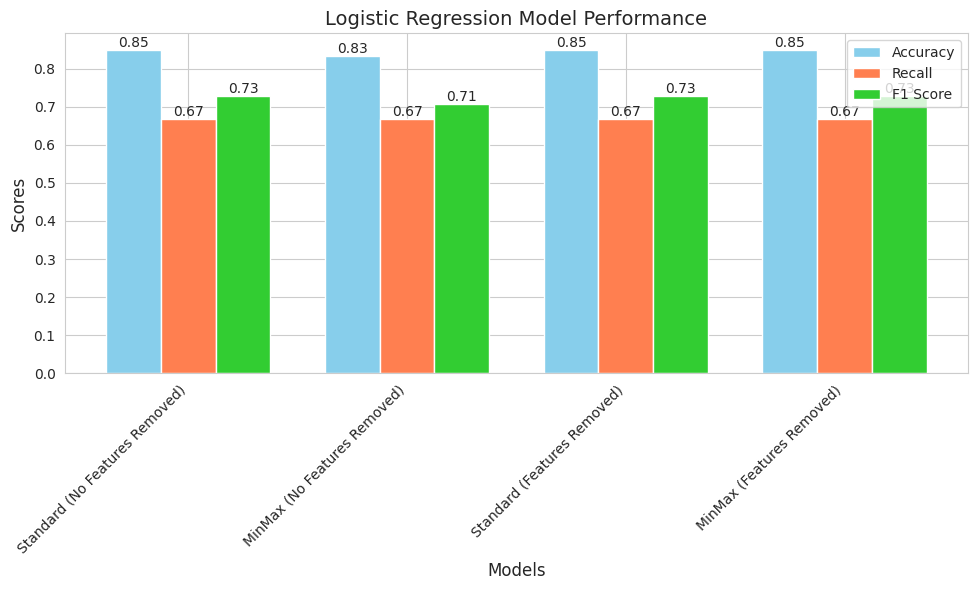

In [ ]:
# Define the models and their corresponding scores
models = ['Standard (No Features Removed)', 'MinMax (No Features Removed)',
          'Standard (Features Removed)', 'MinMax (Features Removed)']

# Assuming you have calculated the scores and stored them in variables
accuracy_scores = [accuracy_logreg_1, accuracy_logreg_2, accuracy_logreg_3, accuracy_logreg_4]
recall_scores = [recall_logreg_1, recall_logreg_2, recall_logreg_3, recall_logreg_4]
f1_scores = [f1score_logreg_1, f1score_logreg_2, f1score_logreg_3, f1score_logreg_4]

# Plotting
plt.figure(figsize=(10, 6))

# Define bar widths and positions
bar_width = 0.25
positions = range(len(models))

# Plot bars for each metric
plt.bar(positions, accuracy_scores, bar_width, color='skyblue', label='Accuracy')
plt.bar([x + bar_width for x in positions], recall_scores, bar_width, color='coral', label='Recall')
plt.bar([x + 2 * bar_width for x in positions], f1_scores, bar_width, color='limegreen', label='F1 Score')

# Set labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Logistic Regression Model Performance', fontsize=14)

# Customize ticks and legend
plt.xticks([x + bar_width for x in positions], models, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Display scores on top of bars
for i, (acc, rec, f1) in enumerate(zip(accuracy_scores, recall_scores, f1_scores)):
    plt.text(i, acc, round(acc, 2), ha='center', va='bottom')
    plt.text(i + bar_width, rec, round(rec, 2), ha='center', va='bottom')
    plt.text(i + 2 * bar_width, f1, round(f1, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()